In [33]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [49]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
import pickle
import plotly.express as px

In [61]:
# nifty50_file = 'data/NIFTY_50_Historical_PR_01012006to13052024.csv'
# mid150_file = 'data/NIFTY_MIDCAP_150_Historical_PR_01012006to13052024.csv'
# sml250_file = 'data/NIFTY_SMALLCAP_250_Historical_PR_01012006to13052024.csv'

nifty50_file = 'data/NIFTY_50_since1990.csv'
mid150_file = 'data/NIFTY_MIDCAP_150_since1990.csv'
sml250_file = 'data/NIFTY_SMALLCAP_250_since1990.csv'

In [62]:
def get_nse_data(nse_file):
    df = pd.read_csv(nse_file)
    df['Date'] = pd.to_datetime(df['Date'], format='%d %b %Y')
    df.set_index('Date', inplace=True)
    return df[~df.index.duplicated()]

In [63]:
def reset_price_tozero(modf,dt):
    modf['nifty50'] = modf['nifty50'] - modf[modf.index == dt]['nifty50'][0]
    modf['mid150'] = modf['mid150'] - modf[modf.index == dt]['mid150'][0]
    modf['sml250'] = modf['sml250'] - modf[modf.index == dt]['sml250'][0]
    return modf

In [64]:
nifty50 = get_nse_data(nifty50_file)
mid150 = get_nse_data(mid150_file)
sml250 = get_nse_data(sml250_file)

In [65]:
merged_data = pd.concat([nifty50['Close'], mid150['Close'], sml250['Close']], axis=1).dropna()
merged_data.columns = ['nifty50', 'mid150', 'sml250']


In [67]:
merged_data.head()

,nifty50,mid150,sml250
Date,,,
2005-04-01,2067.65,1000.00,1000.00
2005-04-04,2063.40,1009.30,1007.50
2005-04-05,2052.55,1002.37,998.77
2005-04-06,2069.30,1011.84,1017.08
2005-04-07,2052.85,1011.98,1018.96


<Axes: xlabel='Date'>

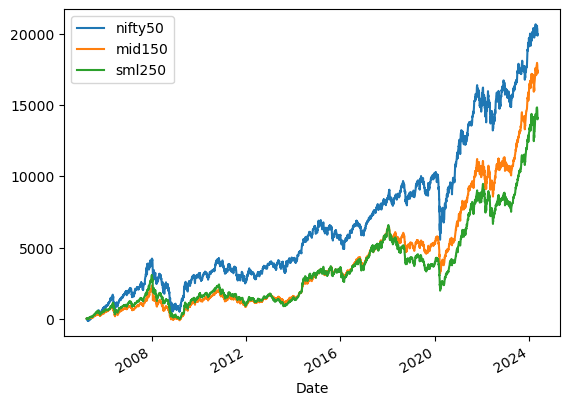

In [68]:
reset_price_tozero(merged_data, '2005-04-01').plot()

C:\Users\d0k03px\AppData\Local\Temp\ipykernel_34616\2637740163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modf['nifty50'] = modf['nifty50'] - modf[modf.index == dt]['nifty50'][0]
C:\Users\d0k03px\AppData\Local\Temp\ipykernel_34616\2637740163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modf['mid150'] = modf['mid150'] - modf[modf.index == dt]['mid150'][0]
C:\Users\d0k03px\AppData\Local\Temp\ipykernel_34616\2637740163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

<Axes: xlabel='Date'>

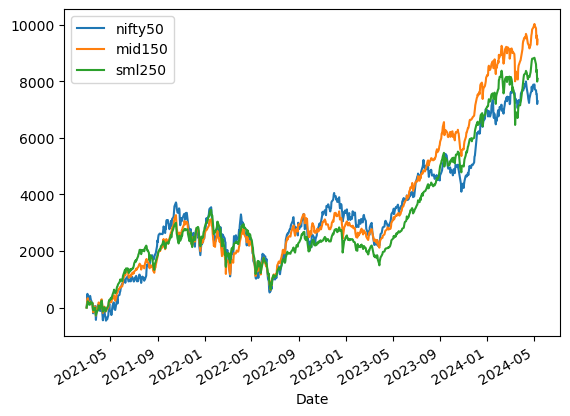

In [72]:
reset_price_tozero(merged_data[merged_data.index > '2021-02-28'], '2021-03-01').plot()

C:\Users\d0k03px\AppData\Local\Temp\ipykernel_34616\2637740163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modf['nifty50'] = modf['nifty50'] - modf[modf.index == dt]['nifty50'][0]
C:\Users\d0k03px\AppData\Local\Temp\ipykernel_34616\2637740163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modf['mid150'] = modf['mid150'] - modf[modf.index == dt]['mid150'][0]
C:\Users\d0k03px\AppData\Local\Temp\ipykernel_34616\2637740163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

<Axes: xlabel='Date'>

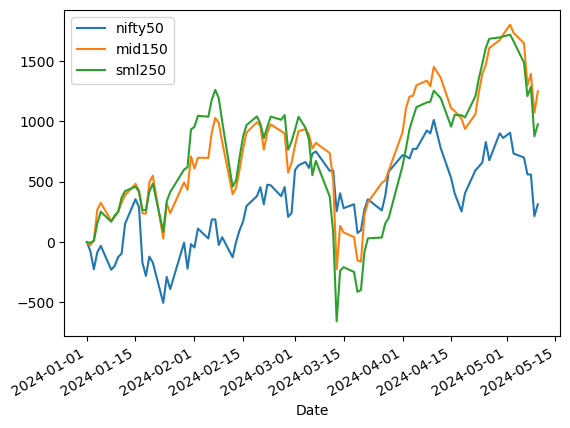

In [71]:
reset_price_tozero(merged_data[merged_data.index > '2023-12-31'], '2024-01-01').plot()

In [75]:
n50_pe_file = 'data/NIFTY50_Historical_PE_PB_DIV_Data_10052022to10052024.csv'
pe = pd.read_csv(n50_pe_file)
pe.rename(columns={'P/E': 'PE'}, inplace=True)
pe['Date'] = pd.to_datetime(pe['Date'], format='%d %b %Y')
pe.set_index('Date', inplace=True)

pe.head()

,Index Name,PE,P/B,Div Yield %
Date,,,,
2024-05-10,NIFTY 50,21.33,3.87,1.36
2024-05-09,NIFTY 50,21.26,3.85,1.21
2024-05-08,NIFTY 50,21.61,3.91,1.19
2024-05-07,NIFTY 50,21.61,3.91,1.19
2024-05-06,NIFTY 50,21.77,3.94,1.16


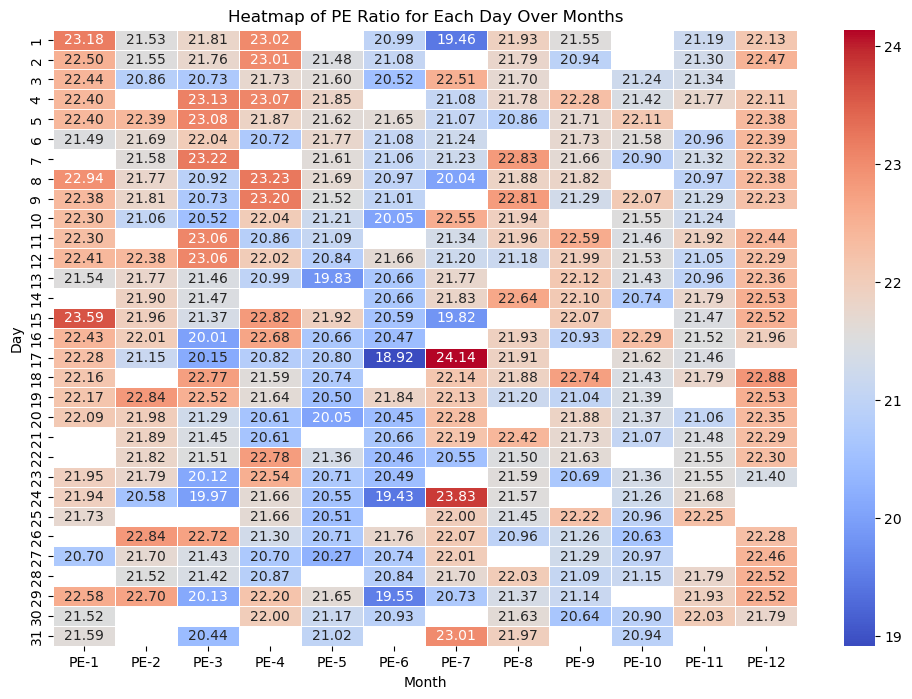

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pe_data = pe[['PE']]
# Pivot the DataFrame to have days as rows and months as columns
pivot_pe_data = pe_data.pivot_table(index=pe_data.index.day,
                                    columns=pe_data.index.month)

# Plot heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(pivot_pe_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Heatmap of PE Ratio for Each Day Over Months')
plt.xlabel('Month')
plt.ylabel('Day')
plt.show()


In [80]:
nifty50_file = 'data/NIFTY_50_since1990.csv'
n50 = get_nse_data(nifty50_file)

n50_pe = pd.merge(n50,pe, )

n50_pe = pd.concat([n50['Close'], pe['PE']], axis=1).dropna()
n50_pe.columns = ['Nifty50', 'pe']

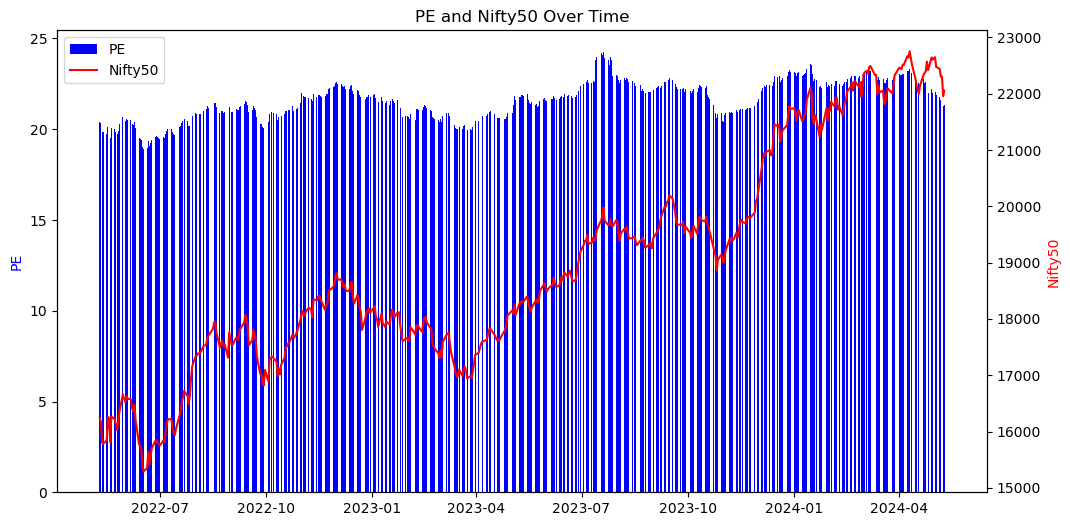

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

df = n50_pe

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for PE
ax1.bar(df.index, df['pe'], color='b', label='PE')
ax1.set_ylabel('PE', color='b')

# Creating a secondary y-axis for Nifty50
ax2 = ax1.twinx()
ax2.plot(df.index, df['Nifty50'], color='r', label='Nifty50')
ax2.set_ylabel('Nifty50', color='r')

# Adding legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adding title
plt.title('PE and Nifty50 Over Time')

plt.show()


In [2]:
N500V50_file = 'data/NIFTY500 VALUE 50_Historical_PR_01042005to02032024.csv'
N200M30_file = 'data/NIFTY200 MOMENTUM 30_Historical_PR_01042005to02032024.csv'

In [3]:
val = pd.read_csv(N500V50_file)
mom = pd.read_csv(N200M30_file)

In [4]:
val.head()

,Index Name,Date,Open,High,Low,Close
0,NIFTY500 VALUE 50,02 Mar 2024,-,-,-,13042.08
1,NIFTY500 VALUE 50,01 Mar 2024,-,-,-,12950.78
2,NIFTY500 VALUE 50,29 Feb 2024,-,-,-,12625.95
3,NIFTY500 VALUE 50,28 Feb 2024,-,-,-,12557.91
4,NIFTY500 VALUE 50,27 Feb 2024,-,-,-,12829.52


In [6]:
val.drop(columns=['Index Name', 'Open', 'High', 'Low'], inplace=True)
val.rename(columns={'Date': 'date'}, inplace=True)
val.rename(columns={'Close': 'N500V50'}, inplace=True)
val['date'] = pd.to_datetime(val['date'])

mom.drop(columns=['Index Name', 'Open', 'High', 'Low'], inplace=True)
mom.rename(columns={'Close': 'N200M30'}, inplace=True)
mom.rename(columns={'Date': 'date'}, inplace=True)
mom['date'] = pd.to_datetime(mom['date'])


In [8]:
val.head()
mom.head()

,date,N200M30
0,2024-03-02,30678.50
1,2024-03-01,30489.20
2,2024-02-29,29990.80
3,2024-02-28,29850.65
4,2024-02-27,30256.95


In [9]:
val.sort_values(by='date', ascending=True, inplace=True)
val.set_index('date', inplace=True)

# Reindex to include all dates (including weekends and holidays)
calendar = pd.date_range(start=val.index.min(), end=val.index.max(), freq='D')
val = val.reindex(calendar)

# Forward fill missing values with previous working day's close price
val['N500V50'] = val['N500V50'].fillna(method='ffill')
val = val[val.index.is_month_end]
val.head()

,N500V50
2005-04-30,944.49
2005-05-31,1040.10
2005-06-30,1010.70
2005-07-31,1123.30
2005-08-31,1182.50


In [10]:
mom.sort_values(by='date', ascending=True, inplace=True)
mom.set_index('date', inplace=True)

# Reindex to include all dates (including weekends and holidays)
calendar = pd.date_range(start=mom.index.min(), end=mom.index.max(), freq='D')
mom = mom.reindex(calendar)

# Forward fill missing values with previous working day's close price
mom['N200M30'] = mom['N200M30'].fillna(method='ffill')
mom = mom[mom.index.is_month_end]
mom.head()

,N200M30
2005-04-30,924.62
2005-05-31,1013.26
2005-06-30,1050.10
2005-07-31,1143.50
2005-08-31,1146.63


In [11]:

def round_to_mon(df):
    # Convert 'date' column to datetime format
    df['date'] = pd.to_datetime(df.index)

    # Set 'year-month' as the index
    df.set_index(df['date'].dt.to_period('M'), inplace=True)

    # Drop the original 'date' column if not needed anymore
    df.drop(columns=['date'], inplace=True)

    return df

In [12]:
val = round_to_mon(val)
mom = round_to_mon(mom)

In [13]:
val.head()

,N500V50
date,
2005-04,944.49
2005-05,1040.10
2005-06,1010.70
2005-07,1123.30
2005-08,1182.50


In [14]:
mom.head()

,N200M30
date,
2005-04,924.62
2005-05,1013.26
2005-06,1050.10
2005-07,1143.50
2005-08,1146.63


In [15]:
dataset_for_ml = pd.merge(val, mom, on='date')
dataset_for_ml.head()

,N500V50,N200M30
date,,
2005-04,944.49,924.62
2005-05,1040.10,1013.26
2005-06,1010.70,1050.10
2005-07,1123.30,1143.50
2005-08,1182.50,1146.63


In [16]:
dataset_for_ml.count()/12

N500V50    18.916667
N200M30    18.916667
dtype: float64

In [18]:
dataset_for_ml.head()

,N500V50,N200M30
date,,
2005-04,944.49,924.62
2005-05,1040.10,1013.26
2005-06,1010.70,1050.10
2005-07,1123.30,1143.50
2005-08,1182.50,1146.63


In [19]:
dataset_for_ml['N500V50_prev_month'] = dataset_for_ml['N500V50'].shift(1)
dataset_for_ml['N200M30_prev_month'] = dataset_for_ml['N200M30'].shift(1)
dataset_for_ml

,N500V50,N200M30,N500V50_prev_month,N200M30_prev_month
date,,,,
2005-04,944.49,924.62,NaN,NaN
2005-05,1040.10,1013.26,944.49,924.62
2005-06,1010.70,1050.10,1040.10,1013.26
2005-07,1123.30,1143.50,1010.70,1050.10
2005-08,1182.50,1146.63,1123.30,1143.50
...,...,...,...,...
2023-10,8882.40,22381.70,9179.96,23231.25
2023-11,9988.46,25061.65,8882.40,22381.70
2023-12,11364.37,27352.70,9988.46,25061.65


In [20]:
dataset_for_ml.drop('2005-04', inplace=True)
dataset_for_ml.head()

,N500V50,N200M30,N500V50_prev_month,N200M30_prev_month
date,,,,
2005-05,1040.1,1013.26,944.49,924.62
2005-06,1010.7,1050.10,1040.10,1013.26
2005-07,1123.3,1143.50,1010.70,1050.10
2005-08,1182.5,1146.63,1123.30,1143.50
2005-09,1226.9,1246.80,1182.50,1146.63


In [21]:
dataset_for_ml['N500V50_%'] = (dataset_for_ml['N500V50'] - dataset_for_ml['N500V50_prev_month'])*100/dataset_for_ml['N500V50_prev_month']

In [22]:
dataset_for_ml['N200M30_%'] = (dataset_for_ml['N200M30'] - dataset_for_ml['N200M30_prev_month'])*100/dataset_for_ml['N200M30_prev_month']

In [23]:
dataset_for_ml.head()

,N500V50,N200M30,N500V50_prev_month,N200M30_prev_month,N500V50_%,N200M30_%
date,,,,,,
2005-05,1040.1,1013.26,944.49,924.62,10.122923,9.586641
2005-06,1010.7,1050.10,1040.10,1013.26,-2.826651,3.635789
2005-07,1123.3,1143.50,1010.70,1050.10,11.140794,8.894391
2005-08,1182.5,1146.63,1123.30,1143.50,5.270186,0.273721
2005-09,1226.9,1246.80,1182.50,1146.63,3.754757,8.736035


In [24]:
dataset_for_ml['mom-val'] = dataset_for_ml['N200M30_%'] - dataset_for_ml['N500V50_%']

In [25]:
dataset_for_ml_final = dataset_for_ml.drop(columns=['N500V50_prev_month', 'N200M30_prev_month', 'N500V50_%', 'N200M30_%'])

In [26]:
dataset_for_ml_final.head()

,N500V50,N200M30,mom-val
date,,,
2005-05,1040.1,1013.26,-0.536282
2005-06,1010.7,1050.10,6.462441
2005-07,1123.3,1143.50,-2.246402
2005-08,1182.5,1146.63,-4.996465
2005-09,1226.9,1246.80,4.981278


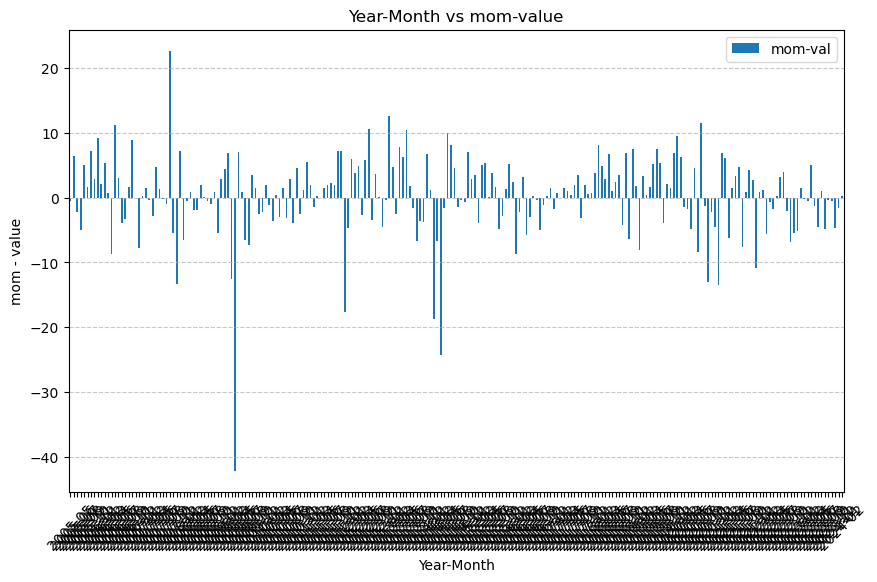

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = dataset_for_ml_final.copy()
df['month'] = df.index
df['mom-val'] = dataset_for_ml['mom-val']
df2 = df[['month', 'mom-val']]

# Plot bar chart
df2.plot(kind='bar', figsize=(10, 6))
plt.title('Year-Month vs mom-value')
plt.xlabel('Year-Month')
plt.ylabel('mom - value')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# df2.head()

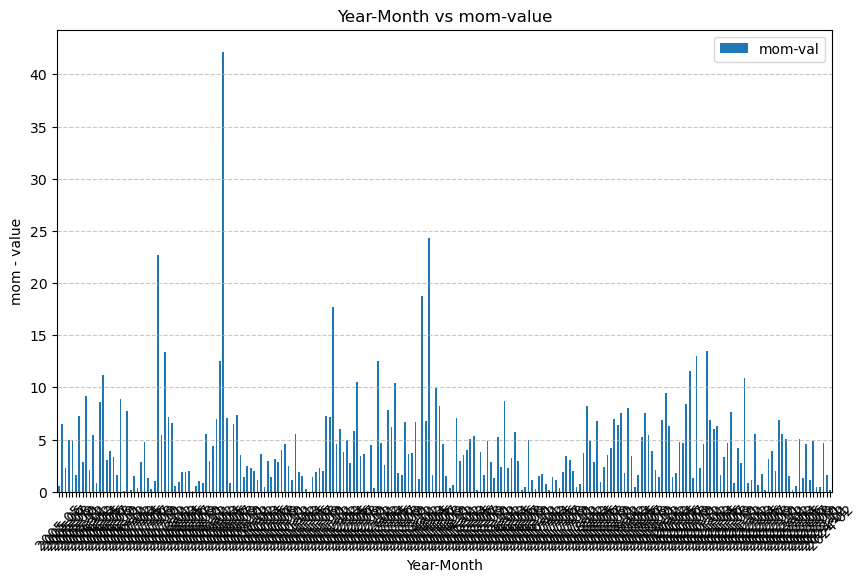

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = dataset_for_ml_final.copy()
df['month'] = df.index
df['mom-val'] = df['mom-val'].abs()
df2 = df[['month', 'mom-val']]

# Plot bar chart
df2.plot(kind='bar', figsize=(10, 6))
plt.title('Year-Month vs mom-value')
plt.xlabel('Year-Month')
plt.ylabel('mom - value')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [29]:
df.max()

N500V50     12625.95
N200M30      29990.8
mom-val    42.171499
month        2024-02
dtype: object

In [30]:
df['mom-val'].cumsum()

date
2005-05      0.536282
2005-06      6.998723
2005-07      9.245126
2005-08     14.241591
2005-09     19.222869
              ...    
2023-10    954.057341
2023-11    954.535761
2023-12    959.169101
2024-01    960.797674
2024-02    961.006308
Freq: M, Name: mom-val, Length: 226, dtype: float64

In [31]:
dataset_for_ml.head()

,N500V50,N200M30,N500V50_prev_month,N200M30_prev_month,N500V50_%,N200M30_%,mom-val
date,,,,,,,
2005-05,1040.1,1013.26,944.49,924.62,10.122923,9.586641,-0.536282
2005-06,1010.7,1050.10,1040.10,1013.26,-2.826651,3.635789,6.462441
2005-07,1123.3,1143.50,1010.70,1050.10,11.140794,8.894391,-2.246402
2005-08,1182.5,1146.63,1123.30,1143.50,5.270186,0.273721,-4.996465
2005-09,1226.9,1246.80,1182.50,1146.63,3.754757,8.736035,4.981278


In [32]:
dataset_for_ml['enhanced%'] = dataset_for_ml.apply(lambda row: row['N200M30_%'] if row['mom-val'] > 0 else row['N500V50_%'], axis=1)
# df['New_Column'] = df.apply(lambda row: row['First_Column'] if row['Third_Column'] > 0 else row['Second_Column'], axis=1)
dataset_for_ml['reco'] = dataset_for_ml.apply(lambda row: 1 if row['mom-val'] < 0 else 0, axis=1)
# dataset_for_ml['new_reco'] = dataset_for_ml.apply(lambda row: row['reco'].shift(1) if row['reco'].shift(1) == row['reco'].shift(-1) else row['reco'], axis=1)
dataset_for_ml.head(20)

,N500V50,N200M30,N500V50_prev_month,N200M30_prev_month,N500V50_%,N200M30_%,mom-val,enhanced%,reco
date,,,,,,,,,
2005-05,1040.1,1013.26,944.49,924.62,10.122923,9.586641,-0.536282,10.122923,1
2005-06,1010.7,1050.10,1040.10,1013.26,-2.826651,3.635789,6.462441,3.635789,0
2005-07,1123.3,1143.50,1010.70,1050.10,11.140794,8.894391,-2.246402,11.140794,1
2005-08,1182.5,1146.63,1123.30,1143.50,5.270186,0.273721,-4.996465,5.270186,1
2005-09,1226.9,1246.80,1182.50,1146.63,3.754757,8.736035,4.981278,8.736035,0
2005-10,1094.7,1132.55,1226.90,1246.80,-10.775124,-9.163458,1.611666,-9.163458,0
2005-11,1187.4,1310.23,1094.70,1132.55,8.468073,15.688491,7.220417,15.688491,0
2005-12,1231.2,1396.20,1187.40,1310.23,3.688732,6.561443,2.872712,6.561443,0
2006-01,1238.2,1532.52,1231.20,1396.20,0.568551,9.763644,9.195093,9.763644,0


In [33]:
df1 = dataset_for_ml[dataset_for_ml.index != '2005-05']
df1.head()

,N500V50,N200M30,N500V50_prev_month,N200M30_prev_month,N500V50_%,N200M30_%,mom-val,enhanced%,reco
date,,,,,,,,,
2005-06,1010.7,1050.10,1040.1,1013.26,-2.826651,3.635789,6.462441,3.635789,0
2005-07,1123.3,1143.50,1010.7,1050.10,11.140794,8.894391,-2.246402,11.140794,1
2005-08,1182.5,1146.63,1123.3,1143.50,5.270186,0.273721,-4.996465,5.270186,1
2005-09,1226.9,1246.80,1182.5,1146.63,3.754757,8.736035,4.981278,8.736035,0
2005-10,1094.7,1132.55,1226.9,1246.80,-10.775124,-9.163458,1.611666,-9.163458,0


In [34]:
dataset_for_ml['new_reco1'] = dataset_for_ml['reco'].shift(1)
dataset_for_ml['new_reco2'] = dataset_for_ml['reco'].shift(-1)
dataset_for_ml = dataset_for_ml[dataset_for_ml.index != '2005-05']
dataset_for_ml['final_reco'] = dataset_for_ml.apply(lambda row: row['new_reco1'] if row['new_reco1'] == row['new_reco2'] else row['reco'], axis=1)

dataset_for_ml.head(20)

C:\Users\d0k03px\AppData\Local\Temp\ipykernel_23248\579652340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_for_ml['final_reco'] = dataset_for_ml.apply(lambda row: row['new_reco1'] if row['new_reco1'] == row['new_reco2'] else row['reco'], axis=1)


,N500V50,N200M30,N500V50_prev_month,N200M30_prev_month,N500V50_%,N200M30_%,mom-val,enhanced%,reco,new_reco1,new_reco2,final_reco
date,,,,,,,,,,,,
2005-06,1010.7,1050.10,1040.1,1013.26,-2.826651,3.635789,6.462441,3.635789,0,1.0,1.0,1.0
2005-07,1123.3,1143.50,1010.7,1050.10,11.140794,8.894391,-2.246402,11.140794,1,0.0,1.0,1.0
2005-08,1182.5,1146.63,1123.3,1143.50,5.270186,0.273721,-4.996465,5.270186,1,1.0,0.0,1.0
2005-09,1226.9,1246.80,1182.5,1146.63,3.754757,8.736035,4.981278,8.736035,0,1.0,0.0,0.0
2005-10,1094.7,1132.55,1226.9,1246.80,-10.775124,-9.163458,1.611666,-9.163458,0,0.0,0.0,0.0
2005-11,1187.4,1310.23,1094.7,1132.55,8.468073,15.688491,7.220417,15.688491,0,0.0,0.0,0.0
2005-12,1231.2,1396.20,1187.4,1310.23,3.688732,6.561443,2.872712,6.561443,0,0.0,0.0,0.0
2006-01,1238.2,1532.52,1231.2,1396.20,0.568551,9.763644,9.195093,9.763644,0,0.0,0.0,0.0
2006-02,1251.3,1579.93,1238.2,1532.52,1.057987,3.093597,2.035610,3.093597,0,0.0,0.0,0.0


In [35]:
dataset_for_ml.to_csv('dataset_for_ml.csv')